In [1]:
import os
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.nn as nn


# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
# which makes intuitive sense.
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import torch.multiprocessing as mp

from torchvision import transforms, datasets, models
from torchvision.io import read_image

from torchinfo import summary

np.random.seed(0)
torch.manual_seed(0)

In [2]:
# torch.cuda.current_device()
# torch.cuda.get_device_name(0)
# torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

Torch is using device: cuda:0


'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [3]:
path_tr = '../../data/CIFAK/train'
path_tst = '../../data/CIFAK/test'

#### Remove Spaces from the Dataset folder to simplify reading from it

In [4]:
# def remove_fname_space(path):
#     for filename in os.listdir(path):
#         my_source = path + "/" + filename
#         my_dest = path + "/" + filename.strip().replace(" ", "")
#         os.rename(my_source, my_dest)


# remove_fname_space(path_tr + "/REAL")
# remove_fname_space(path_tr + "/FAKE")
# remove_fname_space(path_tst + "/REAL")
# remove_fname_space(path_tst + "/FAKE")

#### Gather all the data from the "CIFAK" dataset to be used later

In [5]:
def dataset_data(img_path, folder_name, img_class):
    fname = os.listdir(img_path + "/"+folder_name)
    fname.sort()
    fpath = [img_path + "/"+folder_name+"/" + f for f in fname]
    print(fpath[0])
    labels = [img_class]*len(fname)
    return fpath, labels

In [6]:
fpath_tr_real, labels_tr_real = dataset_data(path_tr, "REAL", 1)
fpath_tr_fake, labels_tr_fake = dataset_data(path_tr, "FAKE", 0)
fpath_tr = fpath_tr_real + fpath_tr_fake
labels_tr = labels_tr_real+labels_tr_fake
tr_dict = {'Image_path': fpath_tr, 'True?': labels_tr}
tr_df = pd.DataFrame(tr_dict)
tr_df.to_csv(path_tr+"/tr_annotation.csv")

fpath_tst_real, labels_tst_real = dataset_data(path_tst, "REAL", 1)
fpath_tst_fake, labels_tst_fake = dataset_data(path_tst, "FAKE", 0)
fpath_tst = fpath_tst_real + fpath_tst_fake
labels_tst = labels_tst_real+labels_tst_fake
tst_dict = {'Image_path': fpath_tst, 'True?': labels_tst}
tst_df = pd.DataFrame(tst_dict)
tst_df.to_csv(path_tst+"/tst_annotation.csv")

../../data/CIFAK/train/REAL/0000(10).jpg
../../data/CIFAK/train/FAKE/1000(10).jpg
../../data/CIFAK/test/REAL/0000(10).jpg
../../data/CIFAK/test/FAKE/0(10).jpg


#### Determine the number of slices (patches) of the image

In [7]:
img_size = cv2.imread(fpath_tr[0]).shape[0]

horizontal_slides= 4
num_loader_images = 16

slice_width = img_size//horizontal_slides
total_img_slices = horizontal_slides**2

slice_width

8

In [8]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # img: is a tensor of the shape (Color_Channels x Rows (Hight) x Columns (Width))
        #
        # Make a slice every "slice_width" as we are moving across dimension 1 (as we are moving
        # vertically across rows)
        img = img.unfold(1, self.slice_width, self.slice_width)
        # Make a slice every slice_width as we are moving across dimension 2,
        # Note that previous operation has added new dimension at the beginning
        # refers to no. of vertical slices, hence 2 here still refers to the rows.
        img = img.unfold(2, self.slice_width, self.slice_width)
        return img

    def __call__(self, img):
        img = self.slice(img)
        channels = img.size(0)

        return img.reshape(-1, self.slice_width * self.slice_width * channels)

    plt.show()

In [9]:
# Define the transforms on the input data (x) tensor
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((32, 32)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    SliceImage(slice_width=slice_width)
])

In [10]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        
        self.annotation = pd.read_csv(annotations_file)
        self.transform = transform

    def __getitem__(self, index):
        
        img = read_image(self.annotation.iloc[index, 1])
        # img.to(device)
        labels = self.annotation.iloc[index, 2]

        if self.transform:
            img_t = self.transform(img)

        return img, img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [11]:
# Define the dataset object and configure the Data Loader
tr_annotation_file = path_tr+"/tr_annotation.csv"
tst_annotation_file = path_tst+"/tst_annotation.csv"

Im_tr_dataset = Images_Dataset(tr_annotation_file, data_transform)

Im_tr_loader = DataLoader(dataset=Im_tr_dataset,
                          batch_size=num_loader_images,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          num_workers=4)


Im_tst_dataset = Images_Dataset(tst_annotation_file, data_transform)

Im_tst_loader = DataLoader(dataset=Im_tst_dataset,
                          batch_size=num_loader_images,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          num_workers=4)

#### Plot the original Image and the slices Image

In [12]:
def img_data(Img_train_loader, index):

    img = Img_train_loader.dataset[index][0]
    img_t = Img_train_loader.dataset[index][1]

    channels = img.size(0)
    img_size = img.size(1)

    total_img_slices = img_t.size(0)
    slice_flat = img_t.size(1)

    imgs_per_batch = Im_tr_loader.batch_size

    slice_width = int(np.sqrt(slice_flat/channels))

    return img, channels, img_size, slice_width, total_img_slices, slice_flat, imgs_per_batch

In [13]:
def img_plot(img, slice_width):
    slice = SliceImage(slice_width)
    sliced_img = slice.slice(img).permute(1, 2, 0, 3, 4)

    fig = plt.figure(layout="constrained", figsize=(4, 4))
    subfigs = fig.subfigures(2, 1,height_ratios=[1., 1.])
    
    axs0 = subfigs[0].subplots(1, 1)
    axs0.imshow(img.permute(1, 2, 0))
    axs0.axis('off')

    grid = ImageGrid(subfigs[1], 111, nrows_ncols=(
        sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        ax.imshow(patch)
        ax.axis('off')

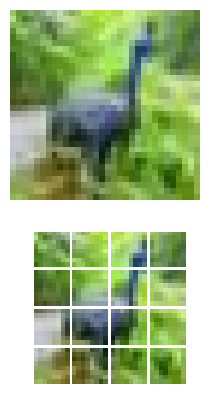

In [14]:
img, ch, img_size, slice_width, slices, slice_flat, batch_size = img_data(
    Im_tr_loader, 2)
img_plot(img, slice_width)

### Build the VIT Model : Embedding &rarr; Transformer Encoder &rarr; MLP_Head

In [15]:
class ImageEmbedding(nn.Module):

    def __init__(self, slice_input_size, slice_embed_size, img_slices, dropout_ratio=0.2):
        super().__init__()

        self.img_to_embed = nn.Linear(slice_input_size, slice_embed_size)
        self.cls_to_embed = nn.Parameter(torch.rand(1, slice_embed_size))
        self.pos_to_embed = nn.Parameter(
            torch.rand(1, img_slices + 1, slice_embed_size))

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, flattened_imgs):
        # the input is a batch of images each has been sliced to patches and each slice
        # has been flattened. i.e. the shape of the input is:
        # [no. of images ,no. of slices per image, size of the flattened image slice]
        #
        img_embedding = self.img_to_embed(flattened_imgs)

        cls_embedding = self.cls_to_embed.repeat(img_embedding.size(0), 1, 1)
        img_embedding = torch.concat([cls_embedding, img_embedding], dim=1)

        position_embedding = self.pos_to_embed.repeat(
            img_embedding.size(0), 1, 1)

        img_and_pos_embedding = img_embedding + position_embedding
        embedding = self.dropout(img_and_pos_embedding)
        return embedding

In [16]:
_, tr_img_t, _ = next(iter(Im_tr_loader))

slice_embed = slice_flat

embedding_layer = ImageEmbedding(slice_input_size=slice_flat,
                                 slice_embed_size=slice_embed,
                                 img_slices=slices,
                                 dropout_ratio=0.2)

embedding_output = embedding_layer(tr_img_t)

print("Input Shape: ", tr_img_t.size())
print("Output Shape: ", embedding_output.size())
# print(embedding_output)

summary(model=embedding_layer,
        input_size=(16, 16, 192),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([16, 16, 192])
Output Shape:  torch.Size([16, 17, 192])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ImageEmbedding (ImageEmbedding)          [16, 16, 192]        [16, 17, 192]        3,456                True
├─Linear (img_to_embed)                  [16, 16, 192]        [16, 16, 192]        37,056               True
├─Dropout (dropout)                      [16, 17, 192]        [16, 17, 192]        --                   --
Total params: 40,512
Trainable params: 40,512
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.59
Input size (MB): 0.20
Forward/backward pass size (MB): 0.39
Params size (MB): 0.15
Estimated Total Size (MB): 0.74

In [17]:
class Encoder(nn.Module):

    def __init__(self, size, num_heads, dropout=0.1):
        super().__init__()

        self.norm_attention = nn.LayerNorm(size)
        self.attention = nn.MultiheadAttention(
            embed_dim=size,
            num_heads=num_heads,
            dropout=0.0,
            bias=True,
            batch_first=True)

        self.norm_feed_forward = nn.LayerNorm(size)
        self.feed_forward = nn.Sequential(
            nn.Linear(size, 4 * size),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(4 * size, size),
            nn.Dropout(dropout))

    def forward(self, input_tensor):
        attn_input = self.norm_attention(input_tensor)
        query = key = value = attn_input
        attn_output,_=self.attention(query=query, key=key, value=value)

        attn_plus_norm = input_tensor + attn_output
        
        mlp_input = self.norm_feed_forward(attn_plus_norm)
        output = attn_plus_norm + self.feed_forward(mlp_input)
        
        return output

In [18]:
encoder_layer = Encoder(size=slice_flat, num_heads=12, dropout=0.1)
encoder_output = encoder_layer(embedding_output)

print("Output Shape: ", encoder_output.size())

summary(model=encoder_layer,
        input_size=(16, 17, 192),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Output Shape:  torch.Size([16, 17, 192])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [16, 17, 192]        [16, 17, 192]        --                   True
├─LayerNorm (norm_attention)             [16, 17, 192]        [16, 17, 192]        384                  True
├─MultiheadAttention (attention)         --                   [16, 17, 192]        148,224              True
├─LayerNorm (norm_feed_forward)          [16, 17, 192]        [16, 17, 192]        384                  True
├─Sequential (feed_forward)              [16, 17, 192]        [16, 17, 192]        --                   True
│    └─Linear (0)                        [16, 17, 192]        [16, 17, 768]        148,224              True
│    └─Dropout (1)                       [16, 17, 768]        [16, 17, 768]        --                   --
│    └─GELU (2)                          [16, 17, 768]        [16, 17, 768]        --                   --
│    └─Linear (3) 

In [19]:
class VIT(nn.Module):
    def __init__(self,
                 slice_input_size,
                 slice_embed_size,
                 img_slices,
                 num_classes,
                 num_heads,
                 num_encoders=1,
                 emb_dropout=0.1,
                 enc_dropout=0.1,
                 lr=1e-4, min_lr=4e-5,
                 weight_decay=0.1,
                 epochs=200):
        super().__init__()

        self.embedding = ImageEmbedding(
            slice_input_size=slice_input_size,
            slice_embed_size=slice_embed_size,
            img_slices=img_slices,
            dropout_ratio=emb_dropout)
        
        self.encoders = nn.Sequential(
            *[Encoder(slice_embed_size, num_heads, dropout=enc_dropout) for _ in range(num_encoders)],)
        
        self.mlp_head = nn.Linear(slice_embed_size, num_classes)

        self.lr = lr
        self.min_lr = min_lr
        self.weight_decay = weight_decay
        self.epochs = epochs

    def forward(self, flattened_img):
        emb = self.embedding(flattened_img)
        attn = self.encoders(emb)
        output = self.mlp_head(attn[:, 0, :])

        return output

In [20]:
slice_embed = slice_flat

vit_layer = VIT(slice_input_size=slice_flat,
                slice_embed_size=slice_embed,
                img_slices=slices,
                num_classes=2,
                num_heads=12,
                num_encoders=2,
                emb_dropout=0.1,
                enc_dropout=0.1,
                lr=1e-4, min_lr=4e-5,
                weight_decay=0.1,
                epochs=200)

vit_output = vit_layer (tr_img_t)

print("Input Shape: ", tr_img_t.size())
print("Output Shape: ", vit_output.size())

summary(model=vit_layer,
        input_size=(16, 16, 192),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([16, 16, 192])
Output Shape:  torch.Size([16, 2])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                          [16, 16, 192]        [16, 2]              --                   True
├─ImageEmbedding (embedding)                       [16, 16, 192]        [16, 17, 192]        3,456                True
│    └─Linear (img_to_embed)                       [16, 16, 192]        [16, 16, 192]        37,056               True
│    └─Dropout (dropout)                           [16, 17, 192]        [16, 17, 192]        --                   --
├─Sequential (encoders)                            [16, 17, 192]        [16, 17, 192]        --                   True
│    └─Encoder (0)                                 [16, 17, 192]        [16, 17, 192]        --                   True
│    │    └─LayerNorm (norm_attention)             [16, 17, 192]        [16, 17, 192]        384                  True
│    │    └─MultiheadAttention (attention)   

In [21]:
# a1= torch.tensor([[[1,2],[3,4],[5,6]]])
# print(a1.size())
# a2= torch.tensor([[[10,20],[30,40]]])
# torch.bmm(a1,a2)